# Loading libraries

In [1]:
# import keras
import fastai
from fastai.vision import *
from fastai.metrics import fbeta, Precision, Recall, accuracy_thresh

import pandas as pd
import numpy as np

import os
import shutil
from pathlib import Path
import tarfile

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_auc_score, recall_score

# Data ingestion

In [2]:
path_raw_data = Path('../../data/full/')
files = os.listdir(path_raw_data)
# files

In [3]:
path_data = path_raw_data/'images'

In [5]:
# verify_images(path_data, n_channels=1)

In [4]:
img_files = os.listdir(path_data)
img_files[:5], len(img_files)

(['00015601_000.png',
  '00008597_003.png',
  '00001931_014.png',
  '00018451_005.png',
  '00019765_001.png'],
 112126)

In [5]:
df_labels = pd.concat([
    pd.read_csv("../model_data/train.csv").assign(subset='train'), 
    pd.read_csv("../model_data/dev.csv").assign(subset='valid'),
    pd.read_csv("../model_data/test.csv").assign(subset='test')
                      ],
                     axis=0)

df_labels = df_labels.loc[df_labels['Image Index'].isin(img_files)]

df_labels.shape

(112120, 18)

For label 'No Finding', we remove the label. 

In [6]:
df_labels.loc[df_labels['Finding Labels'] == 'No Finding', 'Finding Labels'] = ''
df_labels.head()

,Image Index,Patient ID,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,subset
0,00000001_000.png,1,Cardiomegaly,0,1,0,0,0,0,0,0,0,0,0,0,0,0,train
1,00000001_001.png,1,Cardiomegaly|Emphysema,0,1,0,0,0,0,0,0,0,0,1,0,0,0,train
2,00000001_002.png,1,Cardiomegaly|Effusion,0,1,1,0,0,0,0,0,0,0,0,0,0,0,train
3,00000002_000.png,2,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train
4,00000003_000.png,3,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,1,train


In [7]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=False, 
                      max_rotate=5,
                      max_zoom=1.03,
                      max_lighting=0.03,
                      max_warp=0.03,
                      p_affine=0.05,
                      p_lighting=0.05,
                      )

basic_block = (ImageList
                .from_df(df_labels.query('subset!="test"'),
                         path=path_data)
                .split_by_files(valid_names=df_labels.query('subset=="valid"')['Image Index'].tolist())
                .label_from_df(label_delim='|', cols='Finding Labels')
#                 .add_test(ImageList
#                          .from_df(df_labels.query('subset=="test"'),path=path_data)
#                          .split_none()
#                          .label_from_df(label_delim='|', cols='Finding Labels'))
              )

db_xrays = (basic_block
            .transform(tfms, 
                       size=64) 
            .databunch(bs=32))

db_xrays.normalize(imagenet_stats)

db_xrays.export()

## Looking at the data object

In [8]:
db_xrays

ImageDataBunch;

Train: LabelList (104266 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultiCategoryList
Cardiomegaly,Cardiomegaly;Emphysema,Cardiomegaly;Effusion,,Hernia
Path: ../../data/full/images;

Valid: LabelList (6336 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultiCategoryList
,Atelectasis,,Infiltration,Cardiomegaly;Nodule
Path: ../../data/full/images;

Test: None

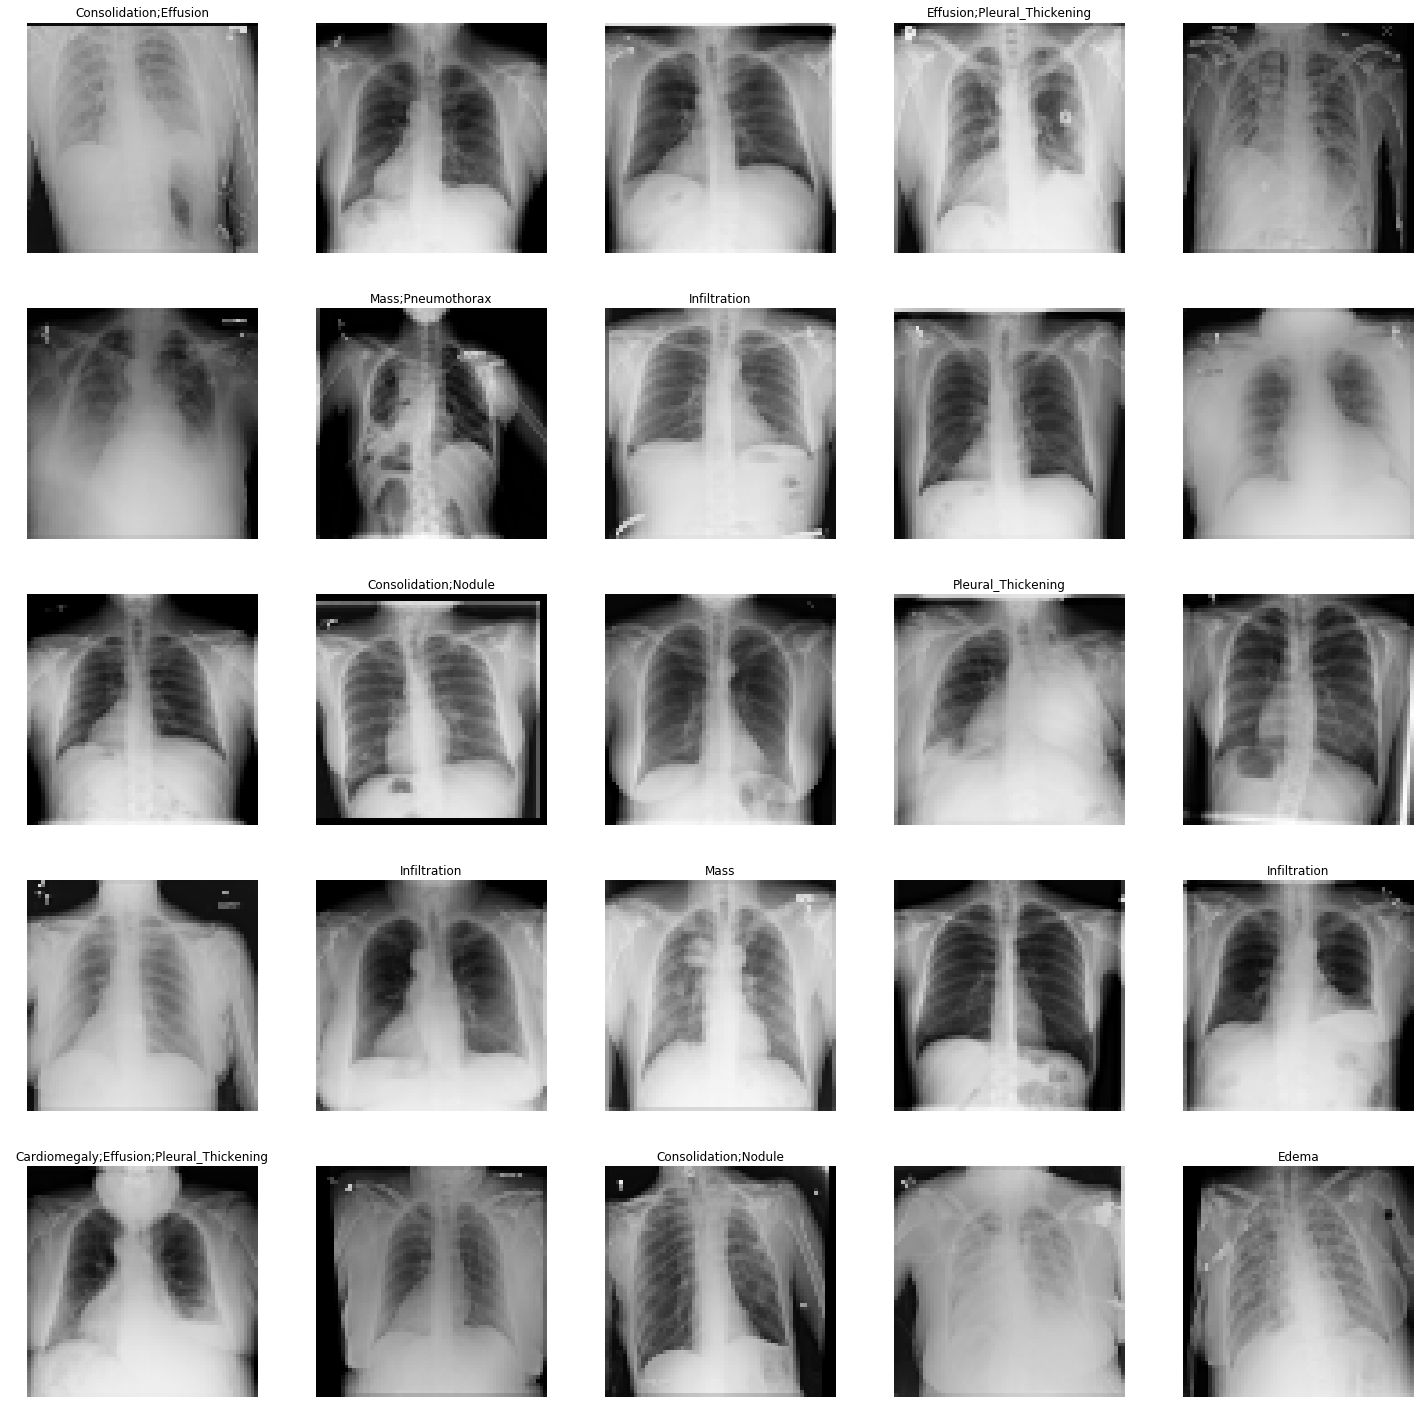

In [9]:
db_xrays.show_batch()

# Training

## Custom metric - AUC

The average AUC for all the classes was the metric that was used in the original paper. I implement it as a callback to be calculated after each epoch.

In [10]:
def auroc_score(input_, target):
    input_, target = input_.cpu().numpy(), target.cpu().numpy() #.reshape(-1, learn.data.c)
    score = []
    for i in range(14):
        try: 
            score.append(roc_auc_score(target[:,i], input_[:,i]))
        except ValueError:
            score.append(0)
    
    return np.array(score).mean()

#     def __init__(self):
#         pass

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = auroc_score(output, target)
            return add_metrics(last_metrics, metric)



## Defining the model

I use a densetnet model **pretrained on IMAGENET**. The transfer learning behavior is turned on by default in fastai.

**Please ignore the accuracy and fbeta. For my consideration only. **

In [11]:
from functools import partial

accuracy_20 = partial(accuracy_thresh, thresh=0.2)
accuracy_50 = partial(accuracy_thresh, thresh=0.5)
f2_20 = partial(fbeta, thresh=0.2, beta=2)
f2_50 = partial(fbeta, thresh=0.5, beta=2)
f1_20 = partial(fbeta, thresh=0.2, beta=1)
f1_50 = partial(fbeta, thresh=0.5, beta=1)


model = cnn_learner(data=db_xrays, 
                   base_arch=models.densenet121,
                   metrics=[AUROC(), 
                            fbeta, 
                            accuracy_20, accuracy_50, 
                            f1_20, f1_50, f2_20, f2_50]
                   )

#### Layers

In [14]:
model.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 32, 32]      9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 32, 32]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 32, 32]      0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 16, 16]      0          False     
______________________________________________________________________
BatchNorm2d          [1, 64, 16, 16]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 16, 16]      0          False     
______________________________________________________________________
Conv2d               [1, 128, 16, 16]     8,192      False     
______________________________________________________________

In [17]:
model.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace)
   (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU(inplace)
   (9): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): ReLU(inplace)
   (15): Conv2d(128, 32, kernel_s

#### Classes

In [18]:
model.data.c, model.data.classes

(14,
 ['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'])

## Training the model

### Stage 1

#### Best learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


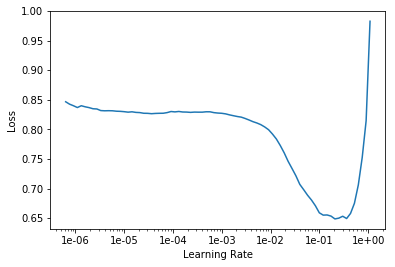

In [19]:
model.lr_find()
model.recorder.plot()

#### 5 epochs with one cycle learning rate policy

Note that the image size is just 64 x 64 now and only the last dense layer is getting trained. 

In [20]:
model.fit_one_cycle(cyc_len=5, max_lr=5e-2)

epoch,train_loss,valid_loss,auroc,fbeta,accuracy_thresh,accuracy_thresh,fbeta,fbeta,fbeta,fbeta,time
0,0.188483,14.831121,0.604056,0.008460,0.914344,0.916858,0.007016,0.003340,0.008460,0.004957,12:06
1,0.191359,0.456436,0.633776,0.102227,0.892587,0.947240,0.082773,0.006884,0.102227,0.006180,12:03
2,0.182827,8.204114,0.671557,0.162144,0.892305,0.944681,0.153836,0.004096,0.162144,0.003992,12:02
3,0.171983,0.213907,0.695710,0.122711,0.923047,0.947657,0.115214,0.005720,0.122711,0.005278,12:04
4,0.170670,0.166897,0.719273,0.120018,0.928244,0.948390,0.115287,0.004872,0.120018,0.004428,12:03


In [22]:
model.save('stage1')

#### Losses

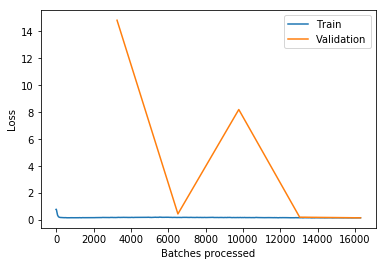

In [28]:
model.recorder.plot_losses()

#### AUC

The AUC is now 71.93%

### Stage 2

In this stage, we

1. **unfreeze** the base densenet model
2. use **discriminative learning rates** to train different layers
3. increase the image size to **128 x 128**. 

In [12]:
model.load('stage1')
model.unfreeze()

In [13]:
model.data = (basic_block
            .transform(tfms, 
                       size=128) 
            .databunch(bs=32))

#### Learning rate for this stage

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


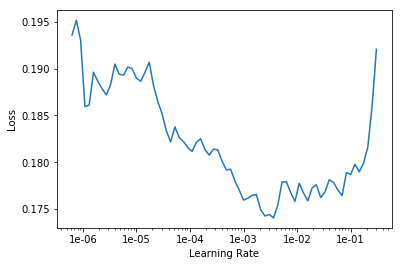

In [31]:
model.lr_find()
model.recorder.plot()

#### Training with discriminative learning rates

In [32]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(5e-6, 3e-5))

epoch,train_loss,valid_loss,auroc,fbeta,accuracy_thresh,accuracy_thresh,fbeta,fbeta,fbeta,fbeta,time
0,0.173437,0.287965,0.688737,0.114151,0.927140,0.947792,0.109610,0.005504,0.114151,0.005008,13:02
1,0.166936,0.189427,0.711273,0.120691,0.928030,0.948379,0.116627,0.007468,0.120691,0.006724,12:59
2,0.164849,0.166025,0.718828,0.117464,0.930341,0.948514,0.113684,0.007797,0.117464,0.007008,13:03
3,0.166356,0.165582,0.720918,0.112181,0.932573,0.948525,0.109848,0.006729,0.112181,0.006057,13:03
4,0.164063,0.165032,0.724028,0.120268,0.930466,0.948514,0.116743,0.007807,0.120268,0.007037,13:03
5,0.159564,0.191841,0.724922,0.122226,0.929203,0.948052,0.117812,0.008619,0.122226,0.007897,13:02


In [37]:
model.save('stage-2')

#### Losses

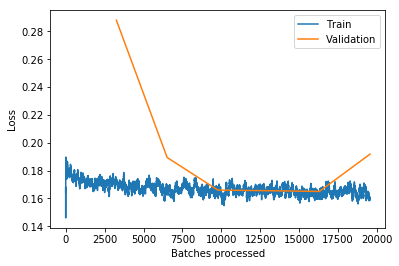

In [34]:
model.recorder.plot_losses()

#### AUC

The AUC is now 72.49%

### Stage 3

In this stage, we

1. increase the image size to **228 x 228**. 

In [14]:
model.load('stage-2');

In [15]:
model.data = (basic_block
            .transform(tfms, 
                       size=228) 
            .databunch(bs=32))

#### Learning rate for this stage

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


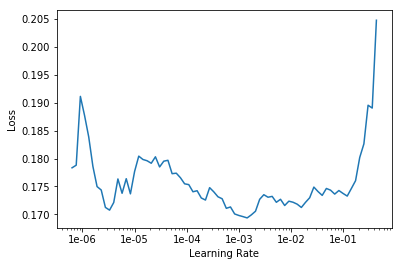

In [70]:
model.lr_find()
model.recorder.plot()

#### Training with discriminative learning rates

In [72]:
model.fit_one_cycle(cyc_len=8, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,auroc,fbeta,accuracy_thresh,accuracy_thresh,fbeta,fbeta,fbeta,fbeta,time
0,0.172080,0.184794,0.702239,0.123287,0.927365,0.948277,0.118440,0.009257,0.123287,0.008442,15:59
1,0.164260,0.167836,0.716748,0.133478,0.924445,0.948514,0.126493,0.007965,0.133478,0.007178,16:01
2,0.160006,0.165080,0.728977,0.126834,0.928831,0.948559,0.122094,0.011974,0.126834,0.010644,15:58
3,0.159460,0.163915,0.736272,0.126859,0.931390,0.948581,0.123402,0.009280,0.126859,0.008363,16:00
4,0.159973,0.174779,0.742638,0.135934,0.927376,0.948424,0.130900,0.015373,0.135934,0.013991,15:56
5,0.154729,0.163148,0.746128,0.131567,0.928988,0.948627,0.127006,0.013269,0.131567,0.012097,15:59
6,0.161920,0.162994,0.746671,0.134344,0.929665,0.948537,0.129639,0.016478,0.134344,0.014968,16:08
7,0.158598,0.170014,0.747654,0.136448,0.927850,0.948582,0.130570,0.018006,0.136448,0.016313,15:46


In [73]:
model.save('stage-3');

#### Losses

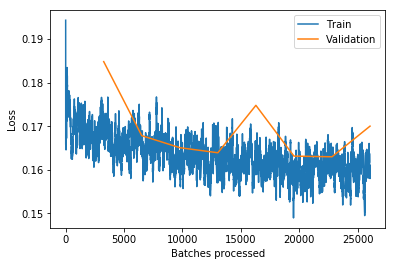

In [74]:
model.recorder.plot_losses()

#### AUC

The AUC is now 74.76%

### Stage 4

In this stage, we

1. increase the image size to **250 x 250**. 

In [16]:
model.load('stage-3');

In [17]:
model.data = (basic_block
            .transform(tfms, 
                       size=250) 
            .databunch(bs=32))

#### Learning rate for this stage

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


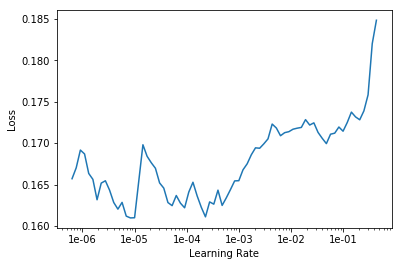

In [77]:
model.lr_find()
model.recorder.plot()

#### Training with discriminative learning rates

In [78]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,auroc,fbeta,accuracy_thresh,accuracy_thresh,fbeta,fbeta,fbeta,fbeta,time
0,0.163743,0.164192,0.748635,0.131814,0.932213,0.948570,0.129088,0.009854,0.131814,0.008925,16:24
1,0.163085,0.161554,0.748976,0.139999,0.927376,0.948615,0.133257,0.018108,0.139999,0.016262,16:24
2,0.157368,0.162479,0.753284,0.141296,0.926238,0.948582,0.134721,0.021220,0.141296,0.019029,16:26
3,0.160510,0.160712,0.756042,0.130060,0.932066,0.948706,0.126725,0.016748,0.130060,0.015290,16:24
4,0.154464,0.162259,0.758902,0.132704,0.931998,0.948627,0.129553,0.014846,0.132704,0.013594,16:25
5,0.155458,0.161193,0.760387,0.145071,0.927343,0.948413,0.138432,0.021041,0.145071,0.019118,16:28


In [79]:
model.save('stage-4');

In [81]:
model.data.export(fname="stage-4-data.pkl")

In [82]:
model.export(fname="stage-4-exp.pkl")

#### Losses

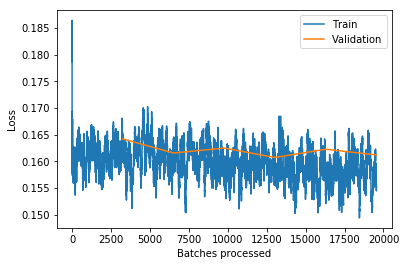

In [80]:
model.recorder.plot_losses()

#### AUC

The AUC is now 76.03%

### Stage 5

In this stage, we

1. increase the image size to **275 x 275**. 

In [18]:
model.load('stage-4');

In [19]:
model.data = (basic_block
            .transform(tfms, 
                       size=275) 
            .databunch(bs=32))

#### Learning rate for this stage

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


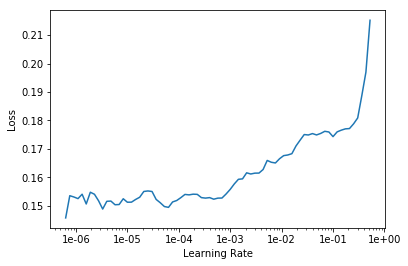

In [86]:
model.lr_find()
model.recorder.plot()

#### Training with discriminative learning rates

In [87]:
model.fit_one_cycle(cyc_len=4, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,auroc,fbeta,accuracy_thresh,accuracy_thresh,fbeta,fbeta,fbeta,fbeta,time
0,0.156910,0.160343,0.758418,0.140745,0.929564,0.948616,0.136116,0.016543,0.140745,0.014786,17:22
1,0.162116,0.160854,0.758329,0.130495,0.932607,0.948728,0.127192,0.014107,0.130495,0.012778,17:21
2,0.159187,0.161557,0.764996,0.138539,0.930296,0.948458,0.134040,0.016462,0.138539,0.014936,17:19
3,0.157039,0.159005,0.765612,0.135876,0.931739,0.948796,0.132315,0.015528,0.135876,0.014040,17:19


In [96]:
model.fit_one_cycle(cyc_len=4, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,auroc,fbeta,accuracy_thresh,accuracy_thresh,fbeta,fbeta,fbeta,fbeta,time
0,0.155487,0.159916,0.765833,0.140101,0.929586,0.948469,0.136260,0.014607,0.140101,0.013214,17:23
1,0.158088,0.159163,0.771810,0.140287,0.930409,0.948672,0.135398,0.020803,0.140287,0.018709,17:21
2,0.158797,0.160478,0.770214,0.149652,0.927286,0.948593,0.142888,0.025850,0.149652,0.023380,17:21
3,0.156320,0.160157,0.773680,0.139494,0.930905,0.948649,0.134839,0.019589,0.139494,0.017641,17:21


In [23]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,auroc,fbeta,accuracy_thresh,accuracy_thresh,fbeta,fbeta,fbeta,fbeta,time
0,0.157521,0.160853,0.771453,0.146972,0.925809,0.948537,0.138835,0.027954,0.146972,0.025316,17:40
1,0.156800,0.159394,0.770514,0.134570,0.932258,0.948559,0.132442,0.015878,0.134570,0.014344,17:41
2,0.154305,0.158826,0.773320,0.144682,0.927918,0.948683,0.138085,0.022949,0.144682,0.020861,17:39
3,0.153403,0.158823,0.777749,0.152843,0.928865,0.948729,0.147165,0.024008,0.152843,0.021846,17:36
4,0.157160,0.160210,0.777740,0.142955,0.931920,0.948875,0.139355,0.022298,0.142955,0.020209,17:34
5,0.150478,0.158930,0.780191,0.151395,0.927782,0.948762,0.144814,0.030921,0.151395,0.028042,17:36


In [27]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,auroc,fbeta,accuracy_thresh,accuracy_thresh,fbeta,fbeta,fbeta,fbeta,time
0,0.154731,0.159139,0.779331,0.151616,0.927478,0.948807,0.145813,0.025639,0.151616,0.023190,17:39
1,0.155851,0.161273,0.771054,0.137577,0.929733,0.948514,0.132206,0.027296,0.137577,0.024670,17:40
2,0.150066,0.159113,0.776494,0.131281,0.933475,0.948796,0.128849,0.013131,0.131281,0.011877,17:38
3,0.156969,0.159873,0.781435,0.147956,0.929924,0.948863,0.143482,0.022877,0.147956,0.020961,17:36
4,0.156666,0.157348,0.783397,0.148628,0.929969,0.948785,0.144105,0.027386,0.148628,0.025104,17:34
5,0.150338,0.163240,0.783482,0.153665,0.927591,0.948909,0.146905,0.030674,0.153665,0.027838,17:32


In [29]:
model.save('stage-5');

In [26]:
model.load('stage-5');

In [30]:
model.data.export(fname="stage-5-data.pkl")

In [31]:
model.export(fname="stage-5-exp.pkl")

#### Losses

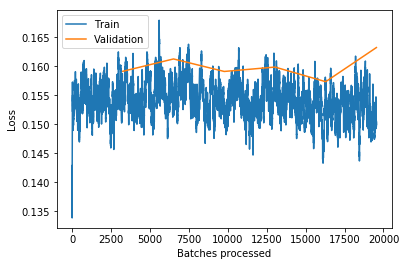

In [32]:
model.recorder.plot_losses()

#### AUC

The AUC is now 78.34%

# Results

## AUROC

### Validation

In [54]:
val_preds = model.get_preds(ds_type=DatasetType.Valid)[0].cpu().numpy()
val_true = df_labels.query('subset=="valid"')[model.data.classes].values

In [55]:
roc_auc_score(val_true, val_preds)

0.7834816540711038

In [56]:
auc_test_classes = {model.data.classes[i]: round(roc_auc_score(val_true[:, i], 
                                                         val_preds[:, i])*100, 2) 
              for i in range(14)}

results = pd.DataFrame(
            {
                'condition' : list(auc_test_classes.keys()),
                'auc' : [f'{i}%' for i in list(auc_test_classes.values())]
            }
        )[['condition', 'auc']]

results

,condition,auc
0,Atelectasis,78.41%
1,Cardiomegaly,87.67%
2,Consolidation,77.46%
3,Edema,88.21%
4,Effusion,85.61%
5,Emphysema,85.41%
6,Fibrosis,77.44%
7,Hernia,76.57%
8,Infiltration,70.55%
9,Mass,74.54%


### Test

In [33]:
model.data.add_test(ImageList
                    .from_df(df_labels.query('subset=="test"'),path=path_data))

In [34]:
test_preds = model.get_preds(ds_type=DatasetType.Test)[0].cpu().numpy()
test_true = df_labels.query('subset=="test"')[model.data.classes].values

In [35]:
roc_auc_score(test_true, test_preds)

0.7462167670911646

In [53]:
auc_test_classes = {model.data.classes[i]: round(roc_auc_score(test_true[:, i], 
                                                         test_preds[:, i])*100, 2) 
              for i in range(14)}

results = pd.DataFrame(
            {
                'condition' : list(auc_test_classes.keys()),
                'auc' : [f'{i}%' for i in list(auc_test_classes.values())]
            }
        )[['condition', 'auc']]

results

,condition,auc
0,Atelectasis,73.17%
1,Cardiomegaly,84.15%
2,Consolidation,77.05%
3,Edema,84.66%
4,Effusion,82.4%
5,Emphysema,81.9%
6,Fibrosis,70.72%
7,Hernia,63.3%
8,Infiltration,69.52%
9,Mass,80.16%
